# UFO 1 data analysis part 1

Big Data házi feladat, UFO1 feladatkör EDA analízise, adatfelderítése.

A használathoz feltételezzük, hogy már létezik egy állomány, data.csv néven, ami tartalmazza a szükséges adatokat.

Ennek a notebooknak a célja, hogy a letöltött adatokkal megismerkedjünk, néhány megfigyelést állapítsunk meg róluk, esetlegesen a nem megfelelő adatokat kiemeljük, és töröljük a készletből.


## Adatok betöltése, átalakítása

Az egyszerű betöltés után néhány kisebb módosítást végeztünk az adatokon:
* Date / Time osztlop átnevezése Date-re, az kezelhetőbbség kedvéért
* Shape oszlop értékei nem voltak konzisztensen kis vagy nagybetűsek, ezért ezeket egységesen csupa lowercase-re konvertáltuk
* A dátumok feldolgozásához a Python saját parser-ét használtuk
    * Amit az nem volt képes feldolgozni, azt egy nem előforduló értékre állítottuk, amit majd később ki lehet szűrni / el lehet dobni
    * Mivel az eredeti adatok szintaxisa miatt jövőbeni adatokat talált a parser, ezért ezeket kézzel módosítottuk

In [1]:
%matplotlib inline
import pandas
import matplotlib
import time
import random
import math
matplotlib.style.use("default")

In [2]:
start = time.time()

# Load data (labels are not included)
raw_data = pandas.read_csv("data.csv", sep=";", encoding="UTF8", header=None, skiprows=1)

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", \
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", \
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", \
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", \
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

data, wrong_data, skipped_lines = [], [], 0
for _, d in raw_data.iterrows():
    try:
        # Transform or validate data
        date = pandas.to_datetime(d[0])
        posted = pandas.to_datetime(d[6])
        state = d[2].upper()
        shape = d[3].lower()
        row = (date, d[1], state, shape, d[4], d[5], posted, d[7])
        
        # Do some checks...
        if date.date() > posted.date():
            wrong_data.append(row)
            continue
        
        if state not in states:
            wrong_data.append(row)
            continue
        
        # Add data to cleaned array
        data.append(row)
    except Exception as e:
        skipped_lines += 1

names = ["Date", "City", "State", "Shape", "Duration", "Summary", "Posted", "Description"]
data = pandas.DataFrame.from_records(data, columns=names)
wrong_data = pandas.DataFrame.from_records(wrong_data, columns=names)

print('Loading data took ' + str(time.time() - start) + 's')
print('Raw data: ' + str(len(raw_data)) + ' lines')
print('Processed data: ' + str(len(data)) + ' lines')
print('Skipped because of parser exception: ' + str(skipped_lines) + ' lines')
print('Wrong data: ' + str(len(wrong_data)) + ' lines')

Loading data took 92.18660855293274s
Raw data: 113241 lines
Processed data: 95343 lines
Skipped because of parser exception: 11651 lines
Wrong data: 6247 lines


## Adatok feltérképezése

### Használt oszlopok és típusai, valamint néhány mintaadat

In [3]:
data.dtypes
sample_data = []
for i in range(10):
    sample_data.append(data.iloc[random.randint(0,len(data))])
pandas.DataFrame.from_records(sample_data, columns=names)

,Date,City,State,Shape,Duration,Summary,Posted,Description
0,2004-07-09 01:15:00,Robertsville,MO,light,10 seconds,White light resembling shooting star creates e...,2004-07-25,NaN
1,2000-07-20 22:00:00,Highlands Ranch,CO,light,10 minutes,We saw a strange red light in the sky south of...,2000-08-05,NaN
2,2013-12-29 18:20:00,Omaha,NE,circle,5 minutes,Bright light traveling southeast over downtown...,2014-01-10,NaN
3,1999-09-05 13:33:00,Hawkinsville,GA,disk,1 min,We saw four saucers with bright lights .,2001-08-05,NaN
4,2007-12-04 21:20:00,Jacksonville,FL,teardrop,2 to 3 sec,Bright blue orb with a tail,2008-03-04,NaN
5,2011-10-23 02:00:00,Hammond,IN,egg,3 to 5 mins,I was sitting outside on the side of my house ...,2011-10-25,NaN
6,2012-10-13 21:21:00,Baton Rouge,LA,triangle,1 minute,"There were two triangles, each formed by three...",2012-10-30,NaN
7,2015-06-08 21:47:00,Hatteras,NC,formation,00:04:00,3 fireballs floating in a line formation over ...,2015-06-15,NaN
8,2008-05-03 21:20:00,Alpine,TX,light,ten minutes,Three reputable witnesses see UFO over west Te...,2008-08-12,NaN
9,2005-05-02 14:05:00,Palmdale,CA,circle,14:15: 10 MIN,Two (2) silver bright round disk(s) that touch...,2005-05-24,NaN


### Adatok vizualizációja az észlelés ideje alapján

count      52.000000
mean     1833.173077
std      2239.904048
min         1.000000
25%       229.500000
50%       312.000000
75%      3505.250000
max      7890.000000
Name: Date, dtype: float64


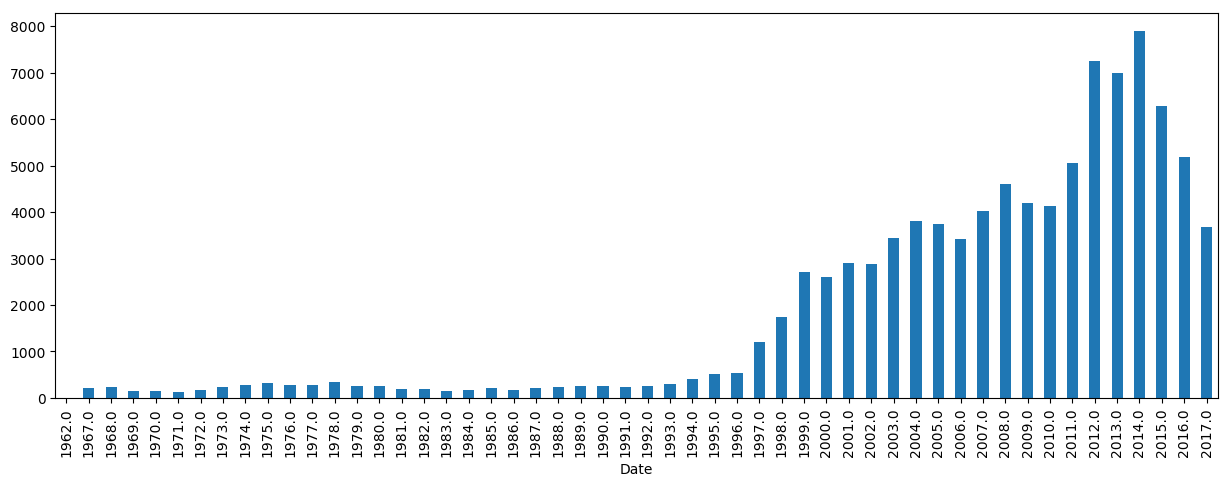

In [4]:
by_year = data.groupby(data["Date"].dt.year).count()["Date"]
print(by_year.describe())
data.groupby(data["Date"].dt.year).count()["Date"].plot(figsize=(15,5),kind="bar")

A vizualizációból látszik, hogy az adatok nagy része 2000 utánról származik.

### Adatok vizualizációja az észlelt ufók száma alapján, alak szerint csoportosítva

count       29.000000
mean      3287.689655
std       4496.506335
min          1.000000
25%          7.000000
50%       1506.000000
75%       5652.000000
max      20216.000000
Name: Shape, dtype: float64


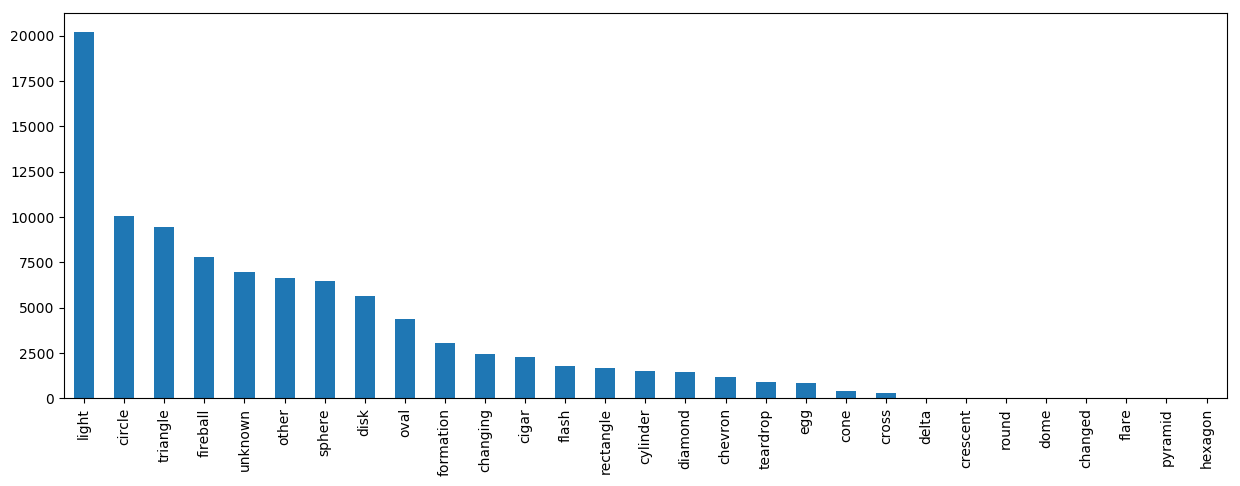

In [5]:
shape_counts = data["Shape"].value_counts()
print(shape_counts.describe())
shape_counts.plot(figsize=(15,5),kind="bar")

### Adatok leíró statisztikái a City és a State oszlop szerint

In [6]:
by_city = data.groupby("City").count()["Date"]
by_city.describe()

count    18162.000000
mean         5.243861
std         17.682276
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        614.000000
Name: Date, dtype: float64

Az adatok város szerinti vizsgálatából látszik, hogy nagyon sok különböző várost adtak meg az adathalmazban, amiből sok olyan van, ami vagy egyszeri észlelés, vagy ami valószínűbb, hogy valami elírás, vagy hibásan felvitt adat.

In [7]:
by_state = data.groupby("State").count()["Date"]
by_state.describe()

count       50.000000
mean      1906.500000
std       2013.154112
min        181.000000
25%        821.500000
50%       1277.000000
75%       2202.500000
max      12350.000000
Name: Date, dtype: float64

Az állam szerinti csoportosításnál úgy tűnik sikeres volt az adatok validációja és transzformációja, mert ezek szerint 1 kivételével mindegyik államból jelentettek észlelést. A qvartilisek, valamint a min és max értékek sem szembetűnően kiugróak a vártakhoz képest.

### Vizualizációs feladat megoldásának terve

A feladat szerint meg kell jelenítenünk az UFO észleléseket térbeli, és időbeli eloszlásuk szerint.
Erre megoldásnak az alábbi vizualizációt tervezzük megvalósítani:
* PySpark segítségével, Map - Reduce módszerrel elkészítjük az egyes évekhez tartozó megfigyelések számát, állam szerint
* Ezeket egy 2D pont diagrammon ábrázoljuk, X tengelyen az államokat, Y tengelyen az éveket.
* Ábrázolásnál az adatok számosságának jelölésére színeket és/vagy méreteket használunk.

A koncepciót az alábbi ábra szemlélteti:

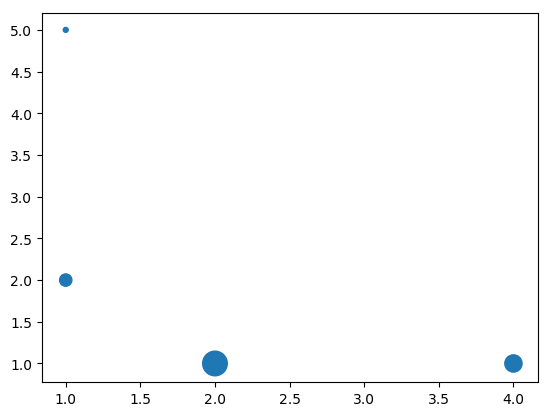

In [8]:
concept = [{"x":2,"y":1,"count":10},{"x":1,"y":2,"count":5},{"x":1,"y":5,"count":2},{"x":4,"y":1,"count":7}]
concept_df = pandas.DataFrame.from_records(concept)
matplotlib.pyplot.scatter(concept_df["x"],concept_df["y"],s=concept_df["count"]**2 * math.pi)
